## Introduction.

I derived the Black-Scholes formula for European style vanilla FX options in a previous post [here](https://quantophile.github.io/mathsummaries/post/2023/11/19/garman-kohlhagen-for-european-vanilla-fx-options/). The Black-Scholes model $Bl(S_0,K,T,r_{DOM},r_{FOR},\sigma)$ equipped with a single flat volatility parameter $\sigma$ produces option prices which are **NOT consistent** with the observed market prices of FX options across different strikes and maturities. 

Although, the BS model suffers many flaws, it is still often used, at least for quoting purposes. Since all of the other inputs into the model - market data variables such as the stock price $S_0$, the domestic depo rate $r_{DOM}$, the foreign depo rate $r_{FOR}$, and the parameters such as option strike $K$, the time-to-maturity $T$, can be either seen in the market or are known constants, we can easily solve for the value $\sigma_{\text{imp}}$ of the parameter $\sigma$ such that:

$$Bl(S_0,K,T,r_{DOM},r_{FOR},\sigma_{\text{imp}}) = V_{\text{market}}$$

This value $\sigma_{\text{imp}}$ implied from the market price of the option is called the **implied volatility**. 

Thus, although the BS model suffers from flaws, it is mainly used as a quote converter. In the FX options market, option prices are quoted in terms of implied volatilities. The BS formula is used to convert implied vols $\sigma_{\text{imp}}$ to prices and vice versa. The delta hedge to be exchanged between counterparties is calculated according to the BS formula, and this is also true for the Vega hedge of various exotic options. In many cases, the model is also used to run trading books. 


In this note, I explore various delta conventions and derive the greeks. Check out [FX Vol smile](https://mathfinance.com/wp-content/uploads/2017/06/CPQF_Arbeits20_neu2.pdf) by Wyestup! The entire concept of the FX volatility smile is based on the parametrization with respect to delta.

## Quote style conversions.

In FX markets, options are quoted in one of 4 quote styles - domestic per foreign (d/f), percentage foreign (%f), percentage domestic (%d) and foreign per domestic (f/d). 

The standard Black-Scholes formula is:

$$
\begin{align}
V_{d/f} &= \omega [S_0 e^{-r_{FOR} T} \Phi(d_{+}) - K e^{-r_{DOM}T} \Phi(d_{-})\\
&= \omega e^{-r_{DOM}T}[F \Phi(d_{+}) - K  \Phi(d_{-})]
\end{align}
$$

Whether a call or a put, it is an option to exchange $K$ units of the domestic currency for $1$ unit of the foreign currency, valued in domestic currency - so it is the domestic/foreign price. 

If we want to express the above as a CCY1/CCY1 price, the conversion is easy : we just take the CCY2/CCY1 price above and convert the CCY2 value into CCY1 terms using today's spot rate $S_0$:

$$
V_{\text{% f}} = \frac{\omega}{S_0}e^{-r_{DOM}T}[F\Phi(\omega d_{+}) - K\Phi(\omega d_{-})] = \frac{V_{d/f}}{S_0}
$$

For the %CCY2 price, we start with the CCY2/CCY1 price, this being the price in CCY2 of an option with a unit notional in the foreign currency. Since the strike is predetermined, it is also the price in CCY2 of an option with a notional of $K$ in CCY2. So, the CCY1/CCY2 price divided by $K$, is the $%ccy2$ price i.e. the percentage domestic price:

$$V_{\%d} = \frac{\omega}{K} e^{-r_{DOM}T}[F \Phi(d_{+}) - K e^{-r_{DOM}T} \Phi(d_{-})] = \frac{V_{d/f}}{K}$$

The ccy1/ccy2 price is the price you need to pay in foreign currency for an option on $1$ unit notional of the domestic currency.

$$V_{f/d} = \frac{V_{\% d}}{S_0} = \frac{V_{d/f}}{S_0 K}$$

The four prices above are relative to the notionals of $K$ in the domestic currency and $1$ in the foreign currency. If the actual notionals are $N_d$ and $N_f$ in domestic and foreign currencies where $N_d = K \cdot N_f$, then we scale accordingly.

### Implementing the Bl Calculator and Option Greeks.

In [3]:
# Author. Quasar C.
# Date. 19-11-2023

import numpy as np
from scipy.stats import norm
from enum import Enum

# An FX option is the right to exchange 1 unit notional of the foreign currency for K units of the domestic currency at time T. 

class CallPut(Enum):
    CALL_OPTION = 1
    PUT_OPTION = -1
        
def atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma):
    foreignDF = np.exp(-r_FOR*(T-t))
    domesticDF = np.exp(-r_DOM*(T-t))
    fwdPoints = foreignDF / domesticDF
    F = fwdPoints * S_t
    return F
        
def dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma):
    F = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return (np.log(F/K) + (T-t)*(sigma**2)/2)/(sigma * np.sqrt(T - t))

def dMinus(S_t,K,t,T,r_DOM,r_FOR,sigma):
    F = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return (np.log(F/K) - (T-t)*(sigma**2)/2)/(sigma * np.sqrt(T - t))

def PV(S_t,K,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut):
    F = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)
    omega = callPut.value
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    d_minus = dMinus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    domesticDF = np.exp(-r_DOM*(T-t))
    
    undiscountedPrice = omega* (F * norm.cdf(omega * d_plus) - K * norm.cdf(omega * d_minus))
    pv = domesticDF * undiscountedPrice * CCY1Notional
    return pv

#### Computing the ATM-Forward and the option price

In [4]:
S_t=1.0549 ; K=1.0710350214586397 ; t=0.0 ;T=1.0 ; r_DOM=0.041039868 ; r_FOR= 0.025860353; sigma=0.08971 ; CCY1Notional=100.00

forward = atTheMoneyForward(S_t,K,t,T,r_DOM,r_FOR,sigma)

call_price = PV(S_t,K,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)
put_price = PV(S_t,K,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)

In [5]:
print(f"Notional = {CCY1Notional} EUR")

print(f"\nAt the money forward = {forward} USD")
print(f"\nCall Price = {call_price} USD pips")
print(f"Put Price = {put_price} USD pips")

print(f"\nCall price = {call_price/S_t} % EUR")
print(f"Put price = {put_price/S_t} % EUR")

print(f"\nCall price = {call_price/K} % USD")
print(f"Put price = {put_price/K} % USD")

print(f"\nCall price = {call_price/(S_t * K)} EUR pips")
print(f"Put price = {put_price/(S_t * K)} EUR pips")

Notional = 100.0 EUR

At the money forward = 1.0710350214586397 USD

Call Price = 3.6777787101031754 USD pips
Put Price = 3.6777787101031754 USD pips

Call price = 3.4863766329540007 % EUR
Put price = 3.4863766329540007 % EUR

Call price = 3.4338547633058893 % USD
Put price = 3.4338547633058893 % USD

Call price = 3.2551471829613132 EUR pips
Put price = 3.2551471829613132 EUR pips


#### Plotting the option price against the CCY1CCY2 spot

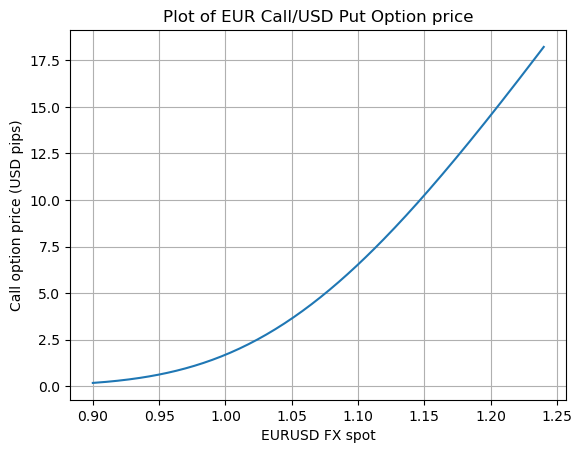

In [45]:
import matplotlib.pyplot as plt

plt.grid(True)
plt.title('Plot of EUR Call/USD Put Option price')
S_t = np.linspace(0.90,1.24,201)
CCY1Notional = 100.00

call_price_1y = PV(S_t,K,t,1.0,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION)

plt.xlabel(r'EURUSD FX spot')
plt.ylabel(r'Call option price (USD pips)')
plt.plot(S_t,call_price_1y)

plt.show()


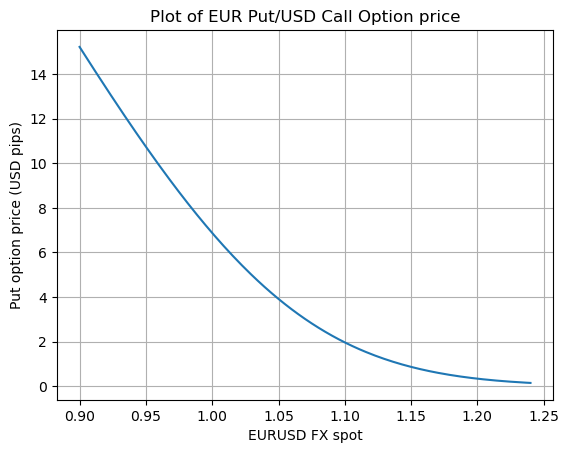

In [7]:
plt.close()

plt.grid(True)
plt.title('Plot of EUR Put/USD Call Option price')

put_price_1y = PV(S_t,K,t,1.0,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION)


plt.xlabel(r'EURUSD FX spot')
plt.ylabel(r'Put option price (USD pips)')

plt.plot(S_t,put_price_1y)

plt.show()

## Outright forward rate.

Consider a contract with payoff at time $T$, $V_T = R_T - K$. The value of this claim at time zero is:

$$
\begin{align*}
v_0 &= e^{-r_{DOM}T}\mathbb{E}^{\mathbb{Q}^d}[R_T - K]\\
&= e^{-r_{DOM}T}(R_0 \mathbb{E}^{\mathbb{Q}^d}[e^{(r_{DOM} - r_{FOR} - (\sigma^2/2))T + \sigma \sqrt{T} Z}] - K)\\
&= e^{-r_{DOM}T}(R_0 e^{(r_{DOM} - r_{FOR})T} - K)\\
&= R_0 e^{- r_{FOR}T} - K e^{-r_{DOM}T}
\end{align*}
$$

The forward price(strike) $K=F_{0,T}$ is set such that, the value of the contract at time zero is $0$. So,

$$
F_{0,T} = K =R_0 e^{(r_{DOM}-r_{FOR})T}
$$

## Put call parity.

We know that, 

$$(S_T - K)^{+} - (K - S_T)^{+} = (S_T - K)$$

By the risk-neutral-pricing formula:

$$\mathbb{E}^{\mathbb{Q}^d}[e^{-r_{DOM}T}(S_T - K)^{+}|\mathcal{F_t}] - \mathbb{E}^{\mathbb{Q}^d}[e^{-r_{DOM}T}(K - S_T)^{+}|\mathcal{F_t}] = \mathbb{E}^{\mathbb{Q}^d}[e^{-r_{DOM}T}(S_T - K)|\mathcal{F_t}]$$

Thus,

$$V_{\text{call}}(t,T) - V_{\text{put}}(t,T) = e^{-r_{FOR}T}S_t - e^{-r_{DOM}T} K = F(t,T)$$

To derive the deltas, we use the following propositions, which are really easy to prove.

***Proposition.*** 

$$\frac{\partial d_{+}}{\partial S_0} = \frac{\partial d_{-}}{\partial S_0} = \frac{1}{\sigma S_0 \sqrt{T}}$$


***Proof***.

We have:

$$
\begin{align*}
d_{\pm} &= \frac{\log {S_0}}{\sigma \sqrt{T}} - \frac{\log {K} + (r \pm \sigma^2/2)T}{\sigma \sqrt{T}}\\
\frac{\partial d_{\pm}}{\partial S_0}&= \frac{1}{\sigma\sqrt{T}}\frac{1}{S_0}
\end{align*}
$$

***Proposition.***

$$\frac{\partial \Phi(\omega d_{\pm})}{\partial S_0} = \frac{\omega}{\sigma S_0 \sqrt{T}}\phi(\omega d_{\pm})$$

***Proof.***

By chain rule, we have:

$$
\begin{align*}
\frac{\partial\Phi(\omega d_{\pm})}{\partial S_0} &= \phi(\omega d_{\pm}) \frac{\partial (\omega d_{\pm})}{dS_0} \\
&= \phi(\omega d_{\pm}) \frac{\omega}{\sigma S_0 \sqrt{T}}
\end{align*}
$$

***Proposition***. The following general result holds:

$$\phi(\omega d_{+}) = \phi(\omega d_{-})\exp(\omega^2 [r_{FOR} - r_{DOM}]T)(K/S_0)^{\omega^2}$$

***Proof.***

We have:

$$
d_{+} + d_{-} = 2 \frac{\log (S_0/K) + (r_{FOR} - r_{DOM})T}{\sigma \sqrt{T}}
$$

$$
d_{+} - d_{-} = \sigma\sqrt{T}
$$

$$
\begin{align*}
\frac{\phi(\omega d_{+})}{\phi(\omega d_{-})} &= \exp\left[-\omega^2\left(\frac{d_{+}^2-d_{-}^2}{2}\right)\right]\\
&= \exp\left[-\omega^2(\log (S_0/K) + (r_{DOM} - r_{FOR})T)\right]\\
&= \exp\left[\omega^2((r_{FOR} - r_{DOM})T)\right](K/S_0)^{\omega^2}
\end{align*}
$$

Also,

$$S_0 e^{-r_{FOR}\tau} \phi(d_{+}) = K e^{-r_{DOM}\tau} \phi(d_{-})$$

***Proposition.*** The following recurring identities hold:

(a) $\frac{\partial d_{+}}{\partial \sigma} = -\frac{d_{\mp}}{\sigma}$

***Proof.***

We have:

$$
\begin{align*}
\frac{\partial d_{\pm}}{\partial \sigma} &= \frac{\partial}{\partial \sigma}\left(\frac{\log (F/K)}{\sigma \sqrt{\tau}} + \frac{1}{2}\sigma{\sqrt{\tau}}\right)\\
&= \left(\frac{-\log (F/K)}{\sigma^2 \sqrt{\tau}} \pm \frac{1}{2}{\sqrt{\tau}}\right)\\
&= -\left(\frac{\log (F/K)}{\sigma^2 \sqrt{\tau}} \mp \frac{\frac{\sigma^2}{2}\tau}{\sigma^2 \sqrt{\tau}}\right)\\
&= -\frac{1}{\sigma}\left(\frac{\log (F/K) \mp \frac{\sigma^2}{2}\tau}{\sigma \sqrt{\tau}}\right)\\
&= -\frac{d_{\mp}}{\sigma}
\end{align*}
$$

(b) $\frac{\partial d_{\pm}}{\partial r_{DOM}} = \frac{\sqrt{\tau}}{\sigma}$

***Proof.***

We have:

$$
\begin{align*}
\frac{\partial d_{\pm}}{\partial r_{DOM}} &= \frac{\partial }{\partial r_{DOM}}\frac{\log (S_0/K) + (r_{DOM} - r_{FOR})\tau \pm (\sigma^2/2)\tau}{\sigma \sqrt{\tau}}\\
&= \frac{\tau}{\sigma \sqrt{\tau}}\frac{\partial}{\partial {r_{DOM}}}(r_{DOM} - r_{FOR})\\
&= \frac{\sqrt{\tau}}{\sigma}
\end{align*}
$$

(c) $\frac{\partial d_{\pm}}{\partial r_{FOR}}= - \frac{\sqrt{\tau}}{\sigma}$

***Proof.***

We have:

$$
\begin{align*}
\frac{\partial d_{\pm}}{\partial r_{FOR}} &= \frac{\sqrt{\tau}}{\sigma}\frac{\partial}{\partial {r_{FOR}}} (r_{DOM} - r_{FOR})\\
&= -\frac{\sqrt{\tau}}{\sigma}
\end{align*}
$$

## Delta

The delta of an option is the percentage of the foreign notional one must buy when you have a short position in an FX option. For instance, a delta of 0.35 indicates buying $35\%$ of the foreign notional to delta hedge the short position. In FX markets, we distinguish between spot delta for a hedge in the spot market and forward delta for a hedge in the outright forward markets. 

### Pips Spot Delta

The pips spot delta is simply the derivative of the option price with respect to the spot rate - both expressed in ccy2/ccy1 terms.

$$\Delta_{S;\text{pips}} = \frac{\partial V_{d;\text{pips}}}{\partial S_0}$$

Thus,

$$
\begin{align*}
\frac{\partial V_{\text{d;pips}}}{\partial S_0} &= \omega\frac{\partial }{\partial S_0} \left[(S_0 e^{-r_{FOR}T} \Phi(\omega d_{+}) - K e^{-r_{DOM}T}\Phi(\omega d_{-})\right)]\\
&= \omega \left[e^{-r_{FOR}T} \Phi(\omega d_{+}) + S_0 e^{-r_{FOR}T} \phi (\omega d_{+})\frac{\omega}{\sigma S_0 \sqrt{T}} - K e^{-r_{DOM}T}\phi (\omega d_{-})\frac{\omega}{\sigma S_0 \sqrt{T}}\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+}) + \frac{\omega^2}{\sigma S_0 \sqrt{T}}\left[S_0 e^{-r_{FOR}T} \phi(\omega d_{+}) - K e^{-r_{DOM}T}\phi(\omega d_{-})\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+}) + \frac{\omega^2}{\sigma S_0 \sqrt{T}}\left[S_0 e^{-r_{FOR}T} e^{(r_{FOR} - r_{DOM})T}\frac{K}{S_0}\phi(\omega d_{-}) - K e^{-r_{DOM}T}\phi(\omega d_{-})\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+}) + \frac{\omega^2}{\sigma S_0 \sqrt{T}}\left[K e^{-r_{DOM}T}\phi(\omega d_{-}) - K e^{-r_{DOM}T}\phi(\omega d_{-})\right]\\
&= \omega e^{-r_{FOR}T} \Phi(\omega d_{+})
\end{align*}
$$

If we think of a delta hedge, it is just the number of units of foreign currency we need to hold in order to hedge an option with a notional of 1 unit of foreign currency and an equivalent notional of $K$ units of domestic currency. So, the spot delta is expressed as a percentage of the foreign currency.

#### Implementing Analytic Delta.

In [8]:
def analyticDelta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION):
    omega = callPut.value
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return omega * np.exp(-r_FOR * (T-t)) * norm.cdf(omega * d_plus) * CCY1Notional

In [9]:
S_t=1.0549 ; CCY1Notional=100.0

pips_spot_delta = analyticDelta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
print(f"Call option Spot Delta = {pips_spot_delta} EUR")
print(f"Spot Delta in percentage = {pips_spot_delta/CCY1Notional * 100} percent")

Call option Spot Delta = 50.466746420569166 EUR
Spot Delta in percentage = 50.466746420569166 percent


#### Plotting the Analytic Delta of call options

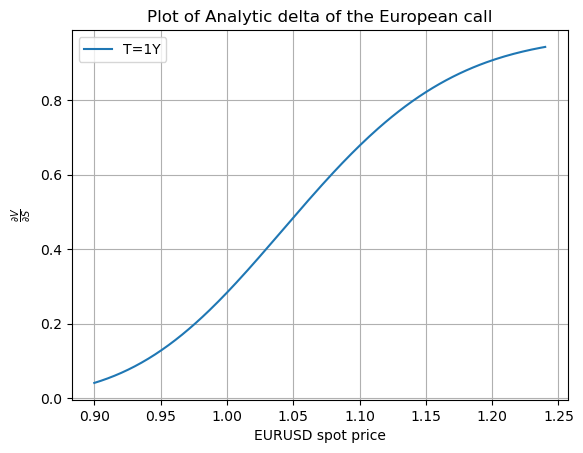

In [10]:
plt.close()

plt.grid(True)
plt.title('Plot of Analytic delta of the European call')
plt.xlabel('EURUSD spot price')
plt.ylabel(r'$\frac{\partial V}{\partial S}$')

S_t = np.linspace(0.90,1.24,201)
CCY1Notional = 1.00
delta = analyticDelta(S_t,K,t,1.0,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
plt.plot(S_t,delta,label='T=1Y')
plt.legend(loc="upper left")
plt.show()

### Pips Forward Delta

The interpretation of the foward delta is the number of units of FOR of forward contracts a trader needs to buy to delta hedge a short option position. 

It is the ratio of the change in the FV of the option with respect to the change in value of the outright forward. 

$$
\Delta_{\text{F;pips}}=e^{r_{DOM}T}\frac{\partial v_{\text{option}}}{\partial F_{0,T}}
$$

So, the derivative of the value of the forward contract with respect to the spot is:

$$\frac{\partial F_{0,T}}{\partial R_0} = e^{(r_{DOM} - r_{FOR})T}$$

Using the chain rule and the derivative of the inverse function, we obtain the forward delta:

$$
\begin{align*}
e^{r_{DOM}T}\frac{\partial v_{\text{option}}}{\partial F_{0,T}} &= e^{r_{DOM}T}\frac{\partial v_{\text{option}}}{\partial R_0} \times \frac{\partial R_0}{\partial F_{0,T}}\\
&=e^{r_{DOM}T} \cdot \omega e^{-r_{FOR}T}\Phi(\omega d_{+}) \times e^{(r_{FOR}- r_{DOM})T}\\
&= \omega \Phi(\omega d_{+})
\end{align*}
$$

In [11]:
def forwardDelta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION):
    omega = callPut.value
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return omega  * norm.cdf(omega * d_plus) * CCY1Notional

In [12]:
S_t=1.0549 ; CCY1Notional=100.00

forward_delta = forwardDelta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
print(f"Forward Delta = {forward_delta } EUR of forward contracts")

Forward Delta = 51.78885572432219 EUR of forward contracts


### Percentage Spot (Premium-adjusted) Delta.

The percentage spot delta is the ratio of the change in the PV of the option expressed in FOR currency terms - to the change in the spot - expressed in FOR currency terms. 

$$
\begin{align*}
\Delta_{S;\%} &= \frac{\partial V_{\% f}}{(\partial S_0)/S_0}\\
&= S_0 \times \frac{\partial}{\partial S_0}\left(\frac{V_{\text{d;pips}}}{S_0}\right)\\
&= S_0 \times \frac{S_0 \frac{\partial V_{\text{d;pips}}}{\partial S_0} - V_{\text{d;pips}} \frac{\partial (S_0)}{\partial S_0}}{S_0^2}\\
&= \frac{(\partial V_{\text{d;pips}}/\partial S_0)S_0 -  V_{\text{d;pips}}}{S_0}\\
&= \frac{\partial V_{\text{d;pips}}}{\partial S_0} - \frac{V_{\text{d;pips}}}{S_0}\\
&= \Delta_{\text{S;pips}} - V_{\% f}
\end{align*}
$$



In [13]:
premiumAdjustedDelta = pips_spot_delta - (call_price/S_t)

print(f"Premium Adjusted Delta = {premiumAdjustedDelta} percent")

Premium Adjusted Delta = 46.98036978761517 percent


## Gamma.

$$
\begin{align*}
\frac{\partial^2 V}{\partial S_0^2} &= \omega e^{-r_{FOR}T} \frac{\partial}{\partial S_0}\Phi(\omega d_{+}) \\
&= \omega e^{-r_{FOR}T} \phi(\omega d_{+}) \frac{\omega}{\sigma S_0 \sqrt{T}}\\
&= e^{-r_{FOR}T} \frac{\phi(\omega d_{+})}{\sigma S_0 \sqrt{T}}
\end{align*}
$$

The interpretation of the gamma is the change of the delta as the spot changes. A high gamma means that the delta hedge must be adapted very frequently and will cause transaction costs. Gamma is typically high when the spot is near a strike of a barrier, generally, whenever the payoff has a kink or dramatically a jump. Trading systems usually quote gamma as a *trader's gamma*, using a one percent relative change in the spot price. 

In [14]:
def analyticGamma(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION):
    omega = callPut.value
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return np.exp(-r_FOR * (T-t)) * norm.cdf(omega * d_plus) / (sigma * S_t * np.sqrt(T-t)) * CCY1Notional

In [15]:
gamma = analyticGamma(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
print(f"Analytic Gamma = {gamma} EUR")

Analytic Gamma = 533.2773740334613 EUR


### Theta.

Let $\tau = T- t$, $\frac{\partial \tau}{\partial t} = -1$. 

We first observe that:

$$
\begin{align*}
d_{-} &= d_{+} - \sigma\sqrt{\tau}\\
\frac{\partial d_{-}}{\partial t} &= \frac{\partial d_{+}}{\partial t} + \frac{\sigma}{2\sqrt{\tau}}
\end{align*}
$$

$$
\begin{align*}
\phi (d_{-}) &= \exp\left[-\frac{1}{2}(d_{+} - \sigma \sqrt{\tau})^2\right]\\
&= \exp\left[-\frac{1}{2}(d_{+}^2 -2 d_{+}\sigma\sqrt{\tau} + \sigma^2 \tau)\right]\\
&= \exp\left(-\frac{1}{2}d_{+}^2\right) \exp(d_{+}\sigma\sqrt{\tau}) \exp(-\frac{1}{2} \sigma^2 \tau)\\
&= \phi(d_{+}) \exp\left(\log \frac{S_0}{K} + (r_{DOM} - r_{FOR} + \frac{\sigma^2}{2})\tau\right) \exp(-\frac{1}{2} \sigma^2 \tau)\\
&= \phi(d_{+}) \frac{S_0}{K} \exp((r_{DOM} - r_{FOR})\tau)\exp(\frac{\sigma^2 \tau}{2}) \exp(-\frac{1}{2} \sigma^2 \tau)\\
&= \frac{S_0}{K} \cdot \phi(d_{+}) e^{(r_{DOM} - r_{FOR})\tau}
\end{align*}
$$

And since $\phi(\omega d_{\pm}) = \phi(d_{\pm})$, we can write:

$$\phi(\omega d_{-})= \frac{S_0}{K} \phi(\omega d_{+}) e^{(r_{DOM} - r_{FOR})\tau}$$

The value function of a vanilla European option is:

$$v_{\text{option}} = \omega [S_0 e^{-r_{FOR}\tau} \Phi(\omega d_{+}) - K e^{-r_{DOM}\tau} \Phi(\omega d_{-})]$$


Differentiating with respect to $t$, we get:

$$\frac{\partial v_{\text{option}}}{\partial t} = \omega[S_0 \frac{\partial }{\partial t}e^{-r_{FOR}\tau}\Phi(\omega d_{+}) - K \frac{\partial }{\partial t} e^{-r_{DOM}\tau}\Phi(\omega d_{-})]$$

The first term can be expressed as:

$$
\begin{align*}
\frac{\partial }{\partial t} e^{-r_{FOR}\tau} \Phi(\omega d_{+}) &= r_{FOR}e^{-r_{FOR}\tau}\Phi(\omega d_{+}) + \omega e^{-r_{FOR}\tau} \phi(\omega d_{+}) \frac{\partial d_{+}}{\partial t}
\end{align*}
$$

The second term can be expressed as:

$$
\begin{align*}
\frac{\partial }{\partial t} e^{-r_{DOM}\tau}\Phi(\omega d_{-}) &= r_{DOM}e^{-r_{DOM}\tau}\Phi(\omega d_{-}) + \omega  e^{-r_{DOM}\tau}\phi(\omega d_{-}) \frac{\partial d_{-}}{\partial t}\\
&=r_{DOM}e^{-r_{DOM}\tau}\Phi(\omega d_{-}) + \omega \cdot \frac{S_0}{K}  e^{-r_{DOM}\tau}\phi(\omega d_{+}) e^{(r_{DOM} - r_{FOR})\tau}\left(\frac{\partial d_{+}}{\partial t} + \frac{\sigma}{2\sqrt{\tau}}\right)\\
&=r_{DOM}e^{-r_{DOM}\tau}\Phi(\omega d_{-}) + \omega \cdot \frac{S_0}{K}  e^{-r_{FOR}\tau}\phi(\omega d_{+}) \left(\frac{\partial d_{+}}{\partial t} + \frac{\sigma}{2\sqrt{\tau}}\right)\\
\end{align*}
$$

Collecting the two terms we have:

$$
\begin{align*}
&S_0 \frac{\partial }{\partial t} e^{-r_{FOR}\tau} \Phi(\omega d_{+}) - K \frac{\partial }{\partial t} e^{-r_{DOM}\tau}\Phi(\omega d_{-}) \\
=& S_0 r_{FOR}e^{-r_{FOR}\tau}\Phi(\omega d_{+}) + \omega S_0 e^{-r_{FOR}\tau} \phi(\omega d_{+}) \frac{\partial d_{+}}{\partial t}\\
-& K r_{DOM}e^{-r_{DOM}\tau}\Phi(\omega d_{-}) - \omega S_0  e^{-r_{FOR}\tau}\phi(\omega d_{+}) \left(\frac{\partial d_{+}}{\partial t} + \frac{\sigma}{2\sqrt{\tau}}\right)\\
=& S_0 r_{FOR}e^{-r_{FOR}\tau}\Phi(\omega d_{+}) - K r_{DOM}e^{-r_{DOM}\tau}\Phi(\omega d_{-}) - \omega S_0  e^{-r_{FOR}\tau}\phi(\omega d_{+}) \frac{\sigma}{2\sqrt{\tau}}
\end{align*}
$$

Therefore,

$$
\begin{align*}
\frac{\partial v_{\text{option}}}{\partial t} &= \omega [S_0 r_{FOR}e^{-r_{FOR}\tau}\Phi(\omega d_{+}) - K r_{DOM}e^{-r_{DOM}\tau}\Phi(\omega d_{-})] \\
&- S_0  e^{-r_{FOR}\tau}\phi(\omega d_{+}) \frac{\sigma}{2\sqrt{\tau}}
\end{align*}
$$

In [16]:
def analyticTheta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION):    
    
    omega = callPut.value
    FOR_df = np.exp(-r_FOR*(T-t)); DOM_df =np.exp(-r_DOM*(T-t));
    dplus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma); dminus = dMinus(S_t,K,t,T,r_DOM,r_FOR,sigma);
    Nd1 = norm.cdf(omega * dplus); Nd2 = norm.cdf(omega * dminus)
    
    theta = (omega * (S_t * r_FOR * FOR_df * Nd1 - K * r_DOM * DOM_df * Nd2) 
            - S_t * FOR_df * Nd1 * (sigma / (2 * np.sqrt(T-t)))) * CCY1Notional
    
    return theta

In [17]:
S_t=1.0549 ; CCY1Notional=100.00

theta = analyticTheta(S_t,K,t,T,r_DOM,r_FOR,sigma,CCY1Notional, callPut = CallPut.CALL_OPTION)
print(f"Analytic Theta = {theta} USD")

Analytic Theta = -3.0451441830007884 USD


Theta reflects the change of the option value as the clock ticks. The *trader's theta* in a risk-management system refers to the change in the option value in one day, i.e. it can be approximated by $365 \frac{\partial v}{\partial t}$.

### Vega.

$$
\begin{align*}
\frac{\partial v}{\partial \sigma} &= \omega[S_0 e^{-r_{FOR}\tau} \frac{\partial}{\partial \sigma}\Phi(\omega d_{+}) - K e^{-r_{DOM}\tau} \frac{\partial}{\partial \sigma}\Phi(\omega d_{-})]\\
 &= \omega[S_0 e^{-r_{FOR}\tau} \phi(\omega d_{+})\frac{\partial d_{+}}{\partial \sigma} - K e^{-r_{DOM}\tau} \phi(\omega d_{-}) \frac{\partial d_{-}}{\partial \sigma}]
\end{align*}
$$

Note that, $d_{-} = d_{+} - \sigma\sqrt{\tau}$, so $\frac{\partial d_{-}}{\partial \sigma} = \frac{\partial d_{+}}{\partial \sigma} - \sqrt{\tau}$. 

Also, $\phi(\omega d_{-})=\frac{K}{S_0}e^{(r_{DOM} - r_{FOR})\tau}\phi(\omega d_{+})$.

Plugging these two facts in the expression for option vega, we get:

$$
\begin{align*}
\frac{\partial v}{\partial \sigma}  &= \omega[S_0 e^{-r_{FOR}\tau} \phi(\omega d_{+})\frac{\partial d_{+}}{\partial \sigma} \\
&- K e^{-r_{DOM}\tau} \frac{K}{S_0}e^{(r_{DOM} - r_{FOR})\tau}\phi(\omega d_{+}) \left(\frac{\partial d_{+}}{\partial \sigma} - \sqrt{\tau}\right)]\\
&= S_0 e^{-r_{FOR}\tau} \phi(\omega d_{+}) \sqrt{\tau}
\end{align*}
$$

### Vanna.

The vanna is *dvega/dspot*. It reflects the change in the vega as the spot moves.

$$
\begin{align*}
\frac{\partial^2 v}{\partial \sigma \partial S_0} &= \frac{\partial}{\partial S_0} \left(\frac{\partial v}{\partial \sigma}\right)\\
&= e^{-r_{FOR}\tau} \sqrt{\tau}\cdot \frac{\partial}{\partial S_0}(S_0\phi(\omega d_{+}))\\
&= e^{-r_{FOR}\tau} \sqrt{\tau}(\phi(\omega d_{+}) + S_0 \frac{\partial}{\partial S_0}\phi(\omega d_{+}))\\
&= e^{-r_{FOR}\tau} \sqrt{\tau}(\phi(\omega d_{+}) + \omega S_0 \frac{\partial}{\partial d_{+}}\phi(\omega d_{+})\cdot \frac{\partial d_{+}}{\partial S_0})\\
&= e^{-r_{FOR}\tau} \sqrt{\tau}(\phi(\omega d_{+}) + \omega S_0\frac{1}{\sqrt{2\pi}} \cdot\frac{\partial}{\partial d_{+}}\exp(-d_{+}^2/2)\cdot \frac{1}{\sigma S_0 \sqrt{\tau}})\\
&= e^{-r_{FOR}\tau} \sqrt{\tau}(\phi(\omega d_{+}) + \omega \frac{1}{\sqrt{2\pi}}e^{-d_{+}^2/2} (-d_{+})\cdot \frac{1}{\sigma \sqrt{\tau}})\\
&= e^{-r_{FOR}\tau} \sqrt{\tau}\phi(\omega d_{+})(1 -  \frac{d_{+}}{\sigma \sqrt{\tau}})\\
&= -e^{-r_{FOR}\tau} \phi(\omega d_{+})\frac{d_{-}}{\sigma}
\end{align*}
$$

### Volga.

The volga is *dvega/dvol*. It reflects the change in the vega as the vol moves.

We have:

$$
\begin{align*}
\frac{d^2 v}{d\sigma^2} &= \frac{\partial}{\partial \sigma} \left(S_0 e^{-r_{FOR}\tau} \phi(\omega d_{+}) \sqrt{\tau}\right)\\
&=S_0 e^{-r_{FOR}\tau} \sqrt{\tau} \cdot \frac{\partial}{\partial \sigma} \phi(\omega d_{+})\\
&=S_0 e^{-r_{FOR}\tau} \sqrt{\tau} \cdot \frac{\partial}{\partial d_{+}}(\phi(\omega d_{+}))\cdot \frac{\partial}{\partial \sigma} d_{+}\\
&=S_0 e^{-r_{FOR}\tau} \sqrt{\tau} \cdot (-d_{+})\phi(\omega d_{+})\cdot \frac{-d_{-}}{\sigma}\\
&=S_0 e^{-r_{FOR}\tau} \sqrt{\tau} \phi(\omega d_{+})\frac{d_{+}d_{-}}{\sigma}
\end{align*}
$$

## Rho.

$$
\begin{align*}
\frac{\partial v}{\partial r_{DOM}} &= \omega \frac{\partial}{\partial r_{DOM}}\left(S_0 e^{-r_{FOR} \tau} \Phi(\omega d_{+}) - K e^{-r_{DOM}\tau} \Phi(\omega d_{-})\right)\\
&= \omega \left[S_0\right]
\end{align*}
$$

## At-The-Money Definitions

The At-the-Money option, as the name suggests, is meant to correspond to, being midway between in-the-money and out-of-the-money. In practice, this is not as obvious:

ATM-Spot : 

$$K = S_0$$

ATM Forward : 

$$K = F_{0,T}$$

ATM value neutral straddle : 

$$K \text{ such that call value = put value}$$

ATM delta neutral straddle :

$$K \text{ such that call delta = -put delta}$$

Since $V_{call} = V_{put}$, when $K = F_{0,T}$, **ATM-value neutral** is equivalent to **ATMF**.

### At-the-money DNS(Delta-neutral-strike)

A more natural way to define an ATM strike is the strike $K_{ATM}$ for which it possible to buy a straddle (long call + long put with strike $K_{ATM}$) that  correponds to a pure long vega position with no net delta. This is called the **Delta-Neutral-Straddle** (DNS) and has the advantage that such a trade can be effected without and spot or forward hedge being needed.

The **Delta-Neutral-Straddle** is defined by $K_{ATM} = K_{DNS}$ where $K_{DNS}$ is chosen such that:

$$ \Delta_{Q}(\text{Call Option}) + \Delta_{Q}(\text{Put Option}) = 0$$

or equivalently,

$$ \Delta_{Q}(\omega=+1,K_{DNS},T,\sigma_{ATM}) + \Delta_{Q}(\omega=-1,K_{DNS},T,\sigma_{ATM}) = 0$$

where $Q$ is the quote convention for the option delta. Now, the deltas can be quoted as spot delta, forward delta, percentage spot delta or percentage forward delta. 

Let's actually solve $K_{DNS}$ analytically in the simplest case of spot and foward delta.

We attempt to solve:

$$
(+1)\Phi\left(+\frac{\log(F/K) + (\sigma_{ATM}^2/2)T}{\sigma\sqrt{T}}\right) + (-1)\Phi\left(-\frac{\log(F/K) + (\sigma_{ATM}^2/2)T}{\sigma\sqrt{T}}\right)=0 
$$

$$
\Phi\left(+\frac{\log(F/K) + (\sigma_{ATM}^2/2)T}{\sigma\sqrt{T}}\right) =\Phi\left(-\frac{\log(F/K) + (\sigma_{ATM}^2/2)T}{\sigma\sqrt{T}}\right) 
$$

Since $\ln(\cdot)$ is monotonic, it follows that:

$$
\begin{align*}
2\log(F/K) + 2(\sigma_{ATM}^2/2)T &= 0\\
\log(F/K) &= - (\sigma_{ATM}^2/2)T \\
\log(K/F) &= (\sigma_{ATM}^2/2)T\\
K_{DNS} &= F_{0,T} e^{\frac{\sigma_{\text{ATM}}^2}{2}T}
\end{align*}
$$

In [18]:
K_DNS = forward * np.exp(((sigma**2)/2)*T)

print(f"ATM delta-neutral Strike = {K_DNS}")

ATM delta-neutral Strike = 1.0753534871192036


## Market Strangles

Suppose that we neglect the effect of volatility skew and presume that volatility, while non-constant across various strikes, is basically symmetric. The concept of the market strangle is that we buy an out-of-the-money put and an out-of-the-money call with strikes placed a similar distance away from the at-the-money strike in moneyness terms. For clarity, let's suppose, we are talking about the 25-delta market strangle, though the market strangle for any delta is pretty similar. 

The idea here is that, without needing to know the actual volatility smile, we can estimate the volatility that is needed to price a market strangle instrument consistently with the market, by taking the at-the-money volatility and adding a strangle premium $\sigma_{25-d-ms}$ to it. The premium thus added, in volatility terms, is called the market strangle.

The important point to make is that the strikes for calls and puts are both calculated subject to the Black-Scholes model with constant volatility of $\sigma_{ATM} + \sigma_{25-d-ms}$; these strikes are known as market strangle strikes $K_{25-d-c-ms}$ and $K_{25-d-p-ms}$. With that, we obtain strikes for calls and puts that have deltas of $+0.25$ and $-0.25$ respectively.

This requires the solution of:

$$
\begin{align*}
\Delta_{Q}(-1, K_{25-d-p-ms},T,\sigma_{ATM}+\sigma_{25-d-ms}) &=-0.25\\
\Delta_{Q}(1, K_{25-d-c-ms},T,\sigma_{ATM}+\sigma_{25-d-ms}) &=0.25
\end{align*}
$$

The crucial part of this, and we return to this point later, is that even if the volatility smile is not symmetric, and therefore neither the call with the strike $K_{25-d-c-ms}$ nor the put with strike $K_{25-d-p-ms}$ should be actually priced with the volatility $\sigma_{ATM} + \sigma_{25-d-ms}$, the aggregate price obtained for the market strangle (long a call with strike $K_{25-d-c-ms}$ and long a put with strike $K_{25-d-p-ms}$) under the actual market volatility smile should be identical to the same aggregate price for the same market strangle instrument, under the assumption of Black-Scholes volatility of $\sigma_{ATM} + \sigma_{25-d-ms}$.

In other words, the market strangle $\sigma_{25-d-ms}$ provides the adjustment to $\sigma_{ATM}$ which is substituted into a Black-Scholes model and used to calculate the $25$-delta call and put strikes and then to price a straddle with those strikes using a full-volatility smile (though the two price components may well differ, the sum must agree).

We put:

$$
V_{25-d-ms} = V(-1,K_{25-d-p-ms},T,\sigma_{ATM}+\sigma_{25-d-ms}) + V(+1,K_{25-d-c-ms},T,\sigma_{ATM}+\sigma_{25-d-ms})
$$

$25\Delta$ market strangles are quoted by $\sigma_{25-d-ms}$.

In [39]:
from scipy import optimize
from scipy.stats import norm

# ---------------------------------------
#   Market Data
# ---------------------------------------
_25dmarket_strangle_quote = 0.004805857
sigma_ATM=0.08971
# ---------------------------------------

sigma = sigma_ATM + _25dmarket_strangle_quote

def spot_delta_call(K):
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return norm.cdf(d_plus) * np.exp(-r_FOR * T)

def spot_delta_put(K):
    d_plus = dPlus(S_t,K,t,T,r_DOM,r_FOR,sigma)
    return (-1)* norm.cdf(-d_plus) * np.exp(-r_FOR * T)

def f(K): return (spot_delta_call(K) - 0.250)
K_25d_call_ms = optimize.brentq(f,0.01,5.00)

def f(K): return(spot_delta_put(K) + 0.250)
K_25d_put_ms = optimize.brentq(f,0.01,5.00)

In [43]:
_25dcallms = PV(S_t,K_25d_call_ms,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.CALL_OPTION) 
_25dputms = PV(S_t,K_25d_put_ms,t,T,r_DOM,r_FOR,sigma, CCY1Notional,callPut = CallPut.PUT_OPTION) 
market_strangle = _25dcallms + _25dputms

print(f"Market Strangle = {market_strangle} USD pips")

Market Strangle = 3.00508046115969 USD pips


## Smile Strangle and Risk Reversal.

The at-the-money volatility and market-strangle volatility provide two degrees of freedom, which allows a volatility smile to be described but without a skew. To introduce a market parameter corresponding to the skew, we use the risk-reversal. In order to do this, we need to suppose that a volatility smile of the form $\sigma_X(K)$ exists, because each european option with different strike $K$ is priced using the smile volatility $\sigma_X(K)$, unlike the at-the-money or market strangle for which we can use a single volatility (which we know in advance from the market data). 

Let's describe the conditions we have on this smile:

$$\sigma_X(K_{ATM}) = \sigma_{ATM} \tag{1}$$

$$V_{25-d-ms} = V(-1, K_{25-d-p-ms},T,\sigma_X(K_{25-d-p-ms})) +  V(+1, K_{25-d-p-ms},T,\sigma_X(K_{25-d-c-ms})) \tag{2}$$

The task is now to find 25-delta smile strikes $K_{25-d-C}$ and $K_{25-d-P}$ for which the Black-Scholes delta is $\pm0.25$ subject to using the smile volatilities $\sigma_X(K_{25-d-C})$ and $\sigma_X(K_{25-d-P})$ respectively. We therefore need to solve:

$$\Delta_{Q}(-1,K_{25-d-P},T,\sigma_X(K_{25-d-P}))=-0.25 \tag{3}$$
$$\Delta_{Q}(-1,K_{25-d-C},T,\sigma_X(K_{25-d-C}))=+0.25 \tag{4}$$

Once these strikes have been determined, we set $\sigma_{25-d-P} = \sigma_{X}(K_{25-d-p})$. The 25-delta risk reversal is calculated from the difference. However, the market generally imposes a sign convention that indicates whether the risk-reversal is defined as $\sigma_{25-d-C} - \sigma_{25-d-P}$  or $\sigma_{25-d-P}-\sigma_{25-d-C}$. We use $\phi_{RR}\in \{1,-1\}$ to denote which is meant, depending on whether risk reversals favor (that is attribute higher implied volatilities to) calls on ccy1/ccy2 or ccy2/ccy1 and put :

$$\sigma_{25-d-RR} = \phi_{RR} \cdot [\sigma_{25-d-C} - \sigma_{25-d-P}] \tag{5}$$

The equations (1), (2) and (5) provide us with the conditions necessary for $\sigma_X(K)$ to be consistent with the market, as parameterized by $\sigma_{ATM}$, $\sigma_{25-d-ms}$ and $\sigma_{25-d-RR}$. If other deltas on the smile are quoted, most commonly $10$-delta, then the conditions (3) and (5) applied in the same way, except using $\sigma_{10-d-ms}$ and $\sigma_{10-d-rr}$. 

It is important to note that the smile strikes $K_{25-d-C}$ and $K_{25-d-P}$ are in general not the same as market strangle strikes $K_{25-d-C-MS}$ and $K_{25-d-P-MS}$. The $25$-delta smile strangle is given by the average volatility of the 25-delta call and 25-delta put, expressed as a premium over the at-the-money volatility:

$$
\sigma_{25-d-SS} = \frac{1}{2}[\sigma_{25-d-C} + \sigma_{25-d-P}] - \sigma_{ATM} \tag{6}
$$

Note that, if $\sigma_{25-d-RR}=0$ in equation (5), then we have $\sigma_{25-d-C}=\sigma_{25-d-P}$ and therefore, $\sigma_{25-d-SS} = \sigma_{25-d-C} - \sigma_{ATM} = \sigma_{25-d-P} - \sigma_{ATM}$. Consequently, $\sigma_{25-d-ms} = \sigma_{25-d-ss}$ in the case where $\sigma_{25-d-RR} = 0$, but in general, this is not so.

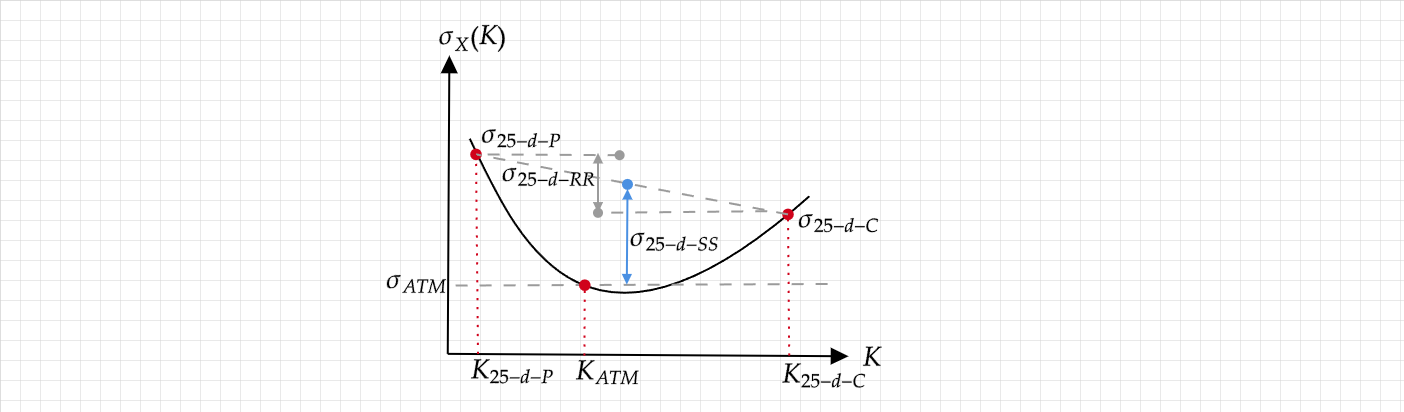

In the figure, the dotted lines indicate the volatilities at the three strikes $K_{ATM}$, $K_{25-d-P}$ and $K_{25-d-C}$. The oblique dotted line connecting the 25-delta call and 25-delta put points on the graph is bisected, so that the midpoint of that line segment has a volatility equal to the average of $\sigma_{25-d-P}$ and $\sigma_{25-d-C}$. The vertical distance of that midpoint above the ATM level is therefore the smile strangle $\sigma_{25-d-SS}$ as indicated in the graph.

The discrepancy between market strangles and smile strangles is the largest for currency pairs with a large skew (that is large absolute values of risk-reversals) e.g. USDJPY. 

We therefore have several strikes - even without including the 10-delta smile, we have 

$$\{K_{25-d-P},K_{25-d-P-ms},K_{ATM},K_{25-d-C},K_{25-d-C-ms}\}$$

There is no unique prescription of $\sigma_X(K)$ and we therefore need to calibrate a smile $\sigma_X(K)$ that satisfies:

$$\sigma_X(K_{ATM}) = \sigma_{ATM}\tag{7}$$

$$V_{25-d-ms} = V(-1,K_{25-d-P-ms},T,\sigma_X(K_{25-d-P-ms})) + V(+1,K_{25-d-P-ms},T,\sigma_X(K_{25-d-C-ms}))\tag{8}$$

$$\sigma_{25-d-RR} = \phi_{RR}[\sigma_X(K_{25-d-C}) - \sigma_X(K_{25-d-P})]\tag {9}$$

where the strikes are determined as detailed above. When these three equations are satisfied, we have:

$$\sigma_{25-d-ss} = \frac{1}{2}[\sigma_X(K_{25-d-C}) + \sigma_X(K_{25-d-P})] - \sigma_X(K_{ATM})$$